<a href="https://colab.research.google.com/github/jinburge/Congressional-Analytics/blob/main/Congressional_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are interested in the spread of how age is related to political affiliation in white males.

Our hypothesis is that: 
- Older white males generally live in the more conservative districts
- Younger white males generally live in democratic districts.







In [ ]:
# read in libraries
import pandas as pd 
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 


First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01001A_002E,B01001A_008E,B01001A_012E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name', 'Total White Male', 'White Male 20-24', 'White Male 45-54', 'State code', 'district number']

# use pandas to parse data 
acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
# extract state, turn district number into numeric (not string)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

# good to do strip on all data source to get rid of whitespace
# strip removes all that
acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total White Male','White Male 20-24', 'White Male 45-54', 'district number', 'State']]

# take a look at the top results in the dataset (first 5)
acs_df

,Total White Male,White Male 20-24,White Male 45-54,district number,State
0,318526,16884,42166,10,Michigan
1,263263,16501,32819,4,Mississippi
2,114430,6881,10618,14,Michigan
3,319908,17699,35549,1,Michigan
4,215967,15873,27003,3,Mississippi
...,...,...,...,...,...
432,337868,20699,41678,6,Missouri
433,335813,23997,40038,7,Missouri
434,241270,13122,31007,5,Michigan
435,286385,20707,34544,6,Michigan


In [ ]:
# Convert the number columns into number data types so we can math on them
acs_df['White Male 20-24'] = pd.to_numeric(acs_df['White Male 20-24'])
acs_df['White Male 45-54'] = pd.to_numeric(acs_df['White Male 45-54'])
acs_df['Total White Male'] = pd.to_numeric(acs_df['Total White Male'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of White Male 20-24 years old'] = (100*acs_df['White Male 20-24'])/acs_df['Total White Male']  
acs_df['% of White Male 45-54 years old'] = (100*acs_df['White Male 45-54'])/ acs_df['Total White Male']   

acs_df

,Total White Male,White Male 20-24,White Male 45-54,district number,State,% of White Male 20-24 years old,% of White Male 45-54 years old
0,318526,16884,42166,10,Michigan,5.300666,13.237852
1,263263,16501,32819,4,Mississippi,6.267877,12.466241
2,114430,6881,10618,14,Michigan,6.013283,9.279035
3,319908,17699,35549,1,Michigan,5.532528,11.112257
4,215967,15873,27003,3,Mississippi,7.349734,12.503299
...,...,...,...,...,...,...,...
432,337868,20699,41678,6,Missouri,6.126357,12.335587
433,335813,23997,40038,7,Missouri,7.145941,11.922707
434,241270,13122,31007,5,Michigan,5.438720,12.851577
435,286385,20707,34544,6,Michigan,7.230476,12.062084


Now let's get our party affiliation data in a state to merge with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
# pd.read_csv("url") - puts in dataframe for you!
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


Let's pull some statistics on the two datasets quickly before we join them so we can sanity check that the join worked ok.

In [ ]:
party_df['State'].value_counts()

California                  53
Texas                       36
New York                    27
Florida                     27
Pennsylvania                18
Illinois                    18
Ohio                        16
Michigan                    14
Georgia                     14
North Carolina              13
New Jersey                  12
Virginia                    11
Washington                  10
Indiana                      9
Arizona                      9
Tennessee                    9
Massachusetts                9
Minnesota                    8
Missouri                     8
Maryland                     8
Wisconsin                    8
Colorado                     7
Alabama                      7
South Carolina               7
Louisiana                    6
Kentucky                     6
Oklahoma                     5
Oregon                       5
Connecticut                  5
Nevada                       4
Kansas                       4
Arkansas                     4
Iowa    

In [ ]:
acs_df['State'].value_counts()

California              53
Texas                   36
Florida                 27
New York                27
Illinois                18
Pennsylvania            18
Ohio                    16
Georgia                 14
Michigan                14
North Carolina          13
New Jersey              12
Virginia                11
Washington              10
Indiana                  9
Massachusetts            9
Arizona                  9
Tennessee                9
Missouri                 8
Wisconsin                8
Minnesota                8
Maryland                 8
South Carolina           7
Alabama                  7
Colorado                 7
Kentucky                 6
Louisiana                6
Connecticut              5
Oklahoma                 5
Oregon                   5
Iowa                     4
Kansas                   4
Arkansas                 4
Mississippi              4
Nevada                   4
Utah                     4
New Mexico               3
West Virginia            3
N

So the ACS dataset has stats for DC and Puerto Rico. The party datset has other terratories like the Virgin Islands. The state counts look right though. Let's go ahead and merge.

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets. 
# two datasets and row by row merge them 
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
# or use head - describe() tells you stats 
merged_df.describe()

,Total White Male,White Male 20-24,White Male 45-54,district number,% of White Male 20-24 years old,% of White Male 45-54 years old
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,231255.248276,14067.280460,28807.714943,10.158621,6.091908,12.418424
std,78701.419354,5816.797023,10114.770378,10.656779,1.435908,1.219489
min,22732.000000,1911.000000,1559.000000,0.000000,2.868717,6.858173
25%,177610.500000,10026.000000,22391.000000,3.000000,5.289973,11.731801
50%,247007.000000,14316.000000,30774.000000,6.000000,5.877615,12.496004
75%,293137.500000,17615.500000,36380.500000,13.000000,6.810703,13.145314
max,477322.000000,36174.000000,54135.000000,53.000000,12.628379,16.523890


There are 435 total rows, which matches up with the number of congress members in the 116th congress. Looks pretty good. Let's do a final check by looking at party counts.

In [ ]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

Let's do our visualization now. We will do a scatter plot of congressional districts and look at the % of households earning over \$200k on one axis and % of households less than $10k on the other axis. We will color the plot based upon the party affiliation of the districts congress member as of the 116th congress.

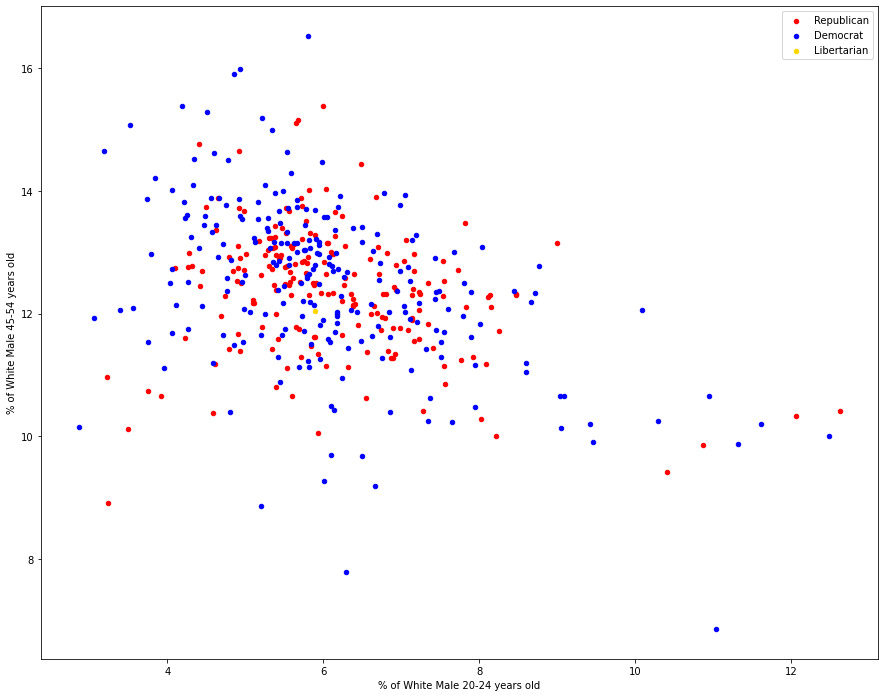

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

#% of White Male 20-24 years old
#% of White Male 45-54 years old

# creating scatterplots, x = , y = , colors 
fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of White Male 20-24 years old', y='% of White Male 45-54 years old', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of White Male 20-24 years old', y='% of White Male 45-54 years old',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of White Male 20-24 years old', y='% of White Male 45-54 years old',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


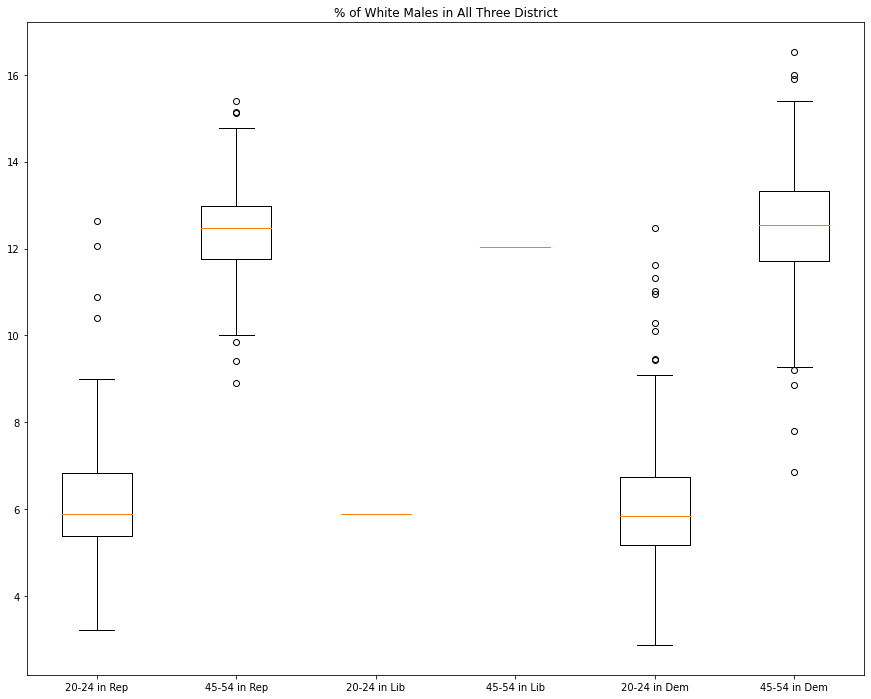

In [ ]:
dataALL = [R['% of White Male 20-24 years old'], R['% of White Male 45-54 years old'],L['% of White Male 20-24 years old'], L['% of White Male 45-54 years old'],D['% of White Male 20-24 years old'], D['% of White Male 45-54 years old']]
fig, ax = plt.subplots(figsize=(15, 12))
ax.boxplot(dataALL)
plt.xticks([1,2,3,4,5,6], ["20-24 in Rep", "45-54 in Rep","20-24 in Lib", "45-54 in Lib","20-24 in Dem", "45-54 in Dem"])
plt.title("% of White Males in All Three District")
plt.show()

What conclusions do you draw from this data? In what ways could this be misleading? Is there a better visualization that you would use here? What would be your followup analysis?

In [ ]:
# saved to csv - snapchat already clean data
merged_df.to_csv("congressional_district_with_parties.csv")

In conclusion, we found that the data disproved our original hypothesis, and that older white males do not generally live in more conservative districts. We found that the republican districts have a smaller spread of white males compared to the democratic districts. 

From the boxplots, we can clearly see that in both the Democratic and Republican districts, there were a greater percentage of white males ages 45-54 than 20-24 years old. Similar to the scatterplot, we found that the republican districts have a smaller spread of white males compared to the democratic districts. 

Therefore, there's not enough information to support our initial hypothesis that there were more older white males in republican districts than democratic as our analysis reveals that age is not a significant factor in political districts. 

